# 1. Data Preparation

This comes from popular Kaggle dataset: [Dataset-Loan Prediction](https://www.kaggle.com/datasets/laotse/credit-risk-dataset/code)

---
Objective of the project is to:

Developed a classifier model to predict loan default risk in the finance industry. The model aimed to minimize potential losses by identifying and preventing high-risk applicants (potential default customers) from receiving loans. The project involved analyzing customer data, selecting relevant features, and implementing a machine learning algorithm to classify applicants as good or bad based on their likelihood of defaulting.




**Below is an overview of dataset features**

```
# This is formatted as code
      Column                      #count          #type   # description
      -----------------------     --------------  ------  -----------------
 1.   person_age                  32416 non-null  int64   : Age

 2.   person_income               32416 non-null  int64   : Annual Income

 3.   person_home_ownership       32416 non-null  object  : Status of home ownership (cat)

 4.   person_emp_length           31529 non-null  float64 : Person employment length (years)

 5.   loan_intent                 32416 non-null  object  : Loan intention (Cat)

 6.   loan_grade                  32416 non-null  object  : Loan Grade (A-F)

 7.   loan_amnt                   32416 non-null  int64   : Loan amount (USD)

 8.   loan_int_rate               29321 non-null  float64 : Interest rate (%)

 9.   loan_status                 32416 non-null  int64   : 0-> non-default, 1-> default

 10.  loan_percent_income         32416 non-null  float64 : loan-income ratio (0-1)

 11.  cb_person_default_on_file   32416 non-null  object  : historical default (T / F)

 12.  cb_person_cred_hist_length  32416 non-null  int64   : credit history length (in years?)
```




## Dependencies

In [ ]:
# Dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#### Functions

def read_data(fname):
  # read file name & drop "url", "names"
  canva = pd.read_csv(fname)
  data = deepcopy(canva)

  data.drop_duplicates(inplace=True)

  print(f"Shape after dropping: {canva.shape}")
  print(f"Shape before dropping: {data.shape}")
  return data

def percent_missing_values(dataframe):
    """
    Calculate the percentage of missing values in each column of a DataFrame.
    """
    missing_value_info = []  # List to store missing value information

    for col in dataframe.columns:
        # catch missing value type na, None and ""
        missing_values = dataframe[col].isna().sum() + \
                         dataframe[col].eq(None).sum() + \
                         (dataframe[col] == '').sum()

        # calculate percentage of missing per colum
        percentage_missing = (missing_values / len(dataframe)) * 100
        print(f"{round(percentage_missing, 2)}% missing values of {col}") ; print("")

def split_input_output(data, target_col):
  """
  :param DataFrame data: targeted DataFrame
  :param str target_col: collumns to be dropped
  """
  y = data[target_col]
  X = data.drop(target_col, axis=1)

  # print out data shape
  print(f"(X) Input shape: {X.shape}")
  print(f"(y) Output shape: {y.shape}")

  return X, y

def split_train_test(input, output, test_size, seed, stratify):

  from sklearn.model_selection import train_test_split

  # first batch Train and temp
  X_train, X_temp, y_train, y_temp = train_test_split(input, output,
                                                              test_size=test_size,
                                                              random_state=seed,
                                                              stratify=stratify)
  ## train ratio
  list_class_train = y_train.value_counts().to_list()
  ratio_train = list_class_train[1] / list_class_train[0]

    ## train ratio
  list_class_temp = y_temp.value_counts().to_list()
  ratio_temp = list_class_temp[1] / list_class_temp[0]

  return X_train, X_temp, y_train, y_temp, ratio_train, ratio_temp

## 1.1 Load data and get overview
---

In [ ]:
path = "/content/credit_risk_dataset.csv"

default_df = read_data(path)

default_df.head(5)

Shape after dropping: (32581, 12)
Shape before dropping: (32416, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
percent_missing_values(default_df)

0.0% missing values of person_age

0.0% missing values of person_income

0.0% missing values of person_home_ownership

2.74% missing values of person_emp_length

0.0% missing values of loan_intent

0.0% missing values of loan_grade

0.0% missing values of loan_amnt

9.55% missing values of loan_int_rate

0.0% missing values of loan_status

0.0% missing values of loan_percent_income

0.0% missing values of cb_person_default_on_file

0.0% missing values of cb_person_cred_hist_length



In [ ]:
default_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

**Insights**

 -  There are some missing values in the feature `person_emp_length` and `loan_int_rate` both of which has a float variable. Therefore we have to consider imputation in numerical features.

 - There are no missing values for categorical features. Therefore, our pipeline only need encoding for these features.

Text(0.5, 1.0, 'Count of Class Instances with Minor-Major Ratio (0.28)')

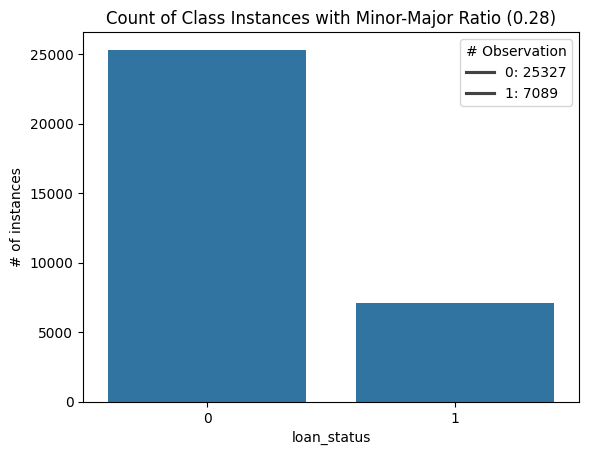

In [ ]:
target_counts = default_df['loan_status'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
ratio= []
labels = []

for i, count in zip(target_counts.index, target_counts.values):
    labels.append(f'{i}: {count}')
    num_str = labels[i][3:]
    num = int(num_str)
    ratio.append(num)

cls_ratio = round(min(ratio) / max(ratio), 2)
plt.legend(title="# Observation", labels=labels)
plt.ylabel("# of instances")
plt.title(f"Count of Class Instances with Minor-Major Ratio ({cls_ratio})")

- There is an imbalance of # Observation in our dataset. This could lead to inaccurate prediction. We have to make sure the distribution of out target class is the same for all sets. we can use sklearn `stratify` function to the target variable.

## 1.2. Split input output and datasets into train, valid, test

In [ ]:
X, y = split_input_output(default_df, "loan_status")

(X) Input shape: (32416, 11)
(y) Output shape: (32416,)


In [ ]:
X_train, X_temp, y_train, y_temp, ratio_train, _ = split_train_test(X, y,
                                                    test_size=0.2, seed=123, stratify=y)

X_valid, X_test, y_valid, y_test, ratio_valid, ratio_test = split_train_test(X_temp, y_temp,
                                                    test_size=0.5, seed=123, stratify=y_temp)

In [ ]:
print(f"X train shape:{X_train.shape} with portion of {round(len(X_train) / len(X),4)}")
print(f"y train shape:{y_train.shape} with portion of {round(len(y_train) / len(y),4)}")
print(f"Ratio of target variable on train set: {ratio_train:.2f}")
print("")

print(f"X valid shape: {X_valid.shape} with portion of {round(len(X_valid) / len(X),4)}")
print(f"y valid shape: {y_valid.shape} with portion of {round(len(y_valid) / len(y),4)}")
print(f"Ratio of target variable on train set: {ratio_valid:.2f}")
print("")

print(f"X test  shape: {X_test.shape} with portion of {round(len(X_test) / len(X),4)}")
print(f"y test  shape: {y_test.shape} with portion of {round(len(y_test) / len(y),4)}")
print(f"Ratio of target variable on train set: {ratio_test:.2f}")

X train shape:(25932, 11) with portion of 0.8
y train shape:(25932,) with portion of 0.8
Ratio of target variable on train set: 0.28

X valid shape: (3242, 11) with portion of 0.1
y valid shape: (3242,) with portion of 0.1
Ratio of target variable on train set: 0.28

X test  shape: (3242, 11) with portion of 0.1
y test  shape: (3242,) with portion of 0.1
Ratio of target variable on train set: 0.28


In [ ]:
X_train.head() ### previous outcome by only splitting the dataset

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9
32528,65,120000,MORTGAGE,0.0,PERSONAL,B,12000,11.48,0.10,N,21
9239,26,24000,RENT,0.0,VENTURE,A,5000,8.90,0.21,N,2
6952,25,50400,MORTGAGE,NaN,HOMEIMPROVEMENT,A,6000,7.14,0.12,N,4


In [ ]:
X_test.head() ## actual data after shuffling

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
2300,26,22406,RENT,5.0,PERSONAL,A,2500,6.76,0.11,N,4
28404,27,120000,MORTGAGE,2.0,EDUCATION,A,7000,7.14,0.06,N,7
7451,26,53000,MORTGAGE,9.0,DEBTCONSOLIDATION,A,8000,7.88,0.15,N,2
18716,27,25200,MORTGAGE,11.0,VENTURE,A,4500,5.42,0.18,N,6
23900,28,24000,RENT,0.0,PERSONAL,C,10000,12.87,0.42,Y,10


In [ ]:
X_valid.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
24293,32,65000,RENT,2.0,VENTURE,C,4200,14.79,0.06,N,10
15065,24,120000,MORTGAGE,0.0,VENTURE,B,15200,12.21,0.13,N,2
21623,35,49800,MORTGAGE,3.0,PERSONAL,A,6000,7.14,0.12,N,6
2338,23,33500,RENT,2.0,EDUCATION,E,2500,15.68,0.07,Y,4
11456,21,45000,RENT,4.0,MEDICAL,A,4000,7.90,0.09,N,3


### Split data into numerical and categorical

In [ ]:
X_train_num = X_train.select_dtypes(include=np.number)

X_train_cat = X_train.select_dtypes(exclude=np.number)

In [ ]:
X_train_num.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
30,21,11520,5.0,2000,11.12,0.17,3
25196,28,80748,5.0,5000,7.51,0.06,9
32528,65,120000,0.0,12000,11.48,0.10,21
9239,26,24000,0.0,5000,8.90,0.21,2
6952,25,50400,NaN,6000,7.14,0.12,4


In [ ]:
X_train_cat.head(5)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
30,OWN,MEDICAL,B,N
25196,MORTGAGE,MEDICAL,A,N
32528,MORTGAGE,PERSONAL,B,N
9239,RENT,VENTURE,A,N
6952,MORTGAGE,HOMEIMPROVEMENT,A,N


## 1.3 Perform EDA and create pre-processing plan

for this purpose we explore the train dataset to make some assumption about our data. To do this, we create a seperate dataframe `train_data` containing all information of our train dataset

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0


Lets explore our target var in train data: `loan_status`


Text(0.5, 1.0, 'Count of Class Instances with Minor-Major Ratio (0.28)')

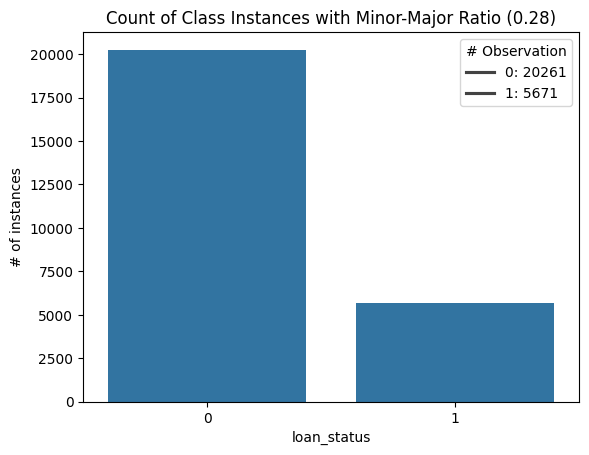

In [ ]:
target_counts = train_data['loan_status'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
ratio= []
labels = []

for i, count in zip(target_counts.index, target_counts.values):
    labels.append(f'{i}: {count}')
    num_str = labels[i][3:]
    num = int(num_str)
    ratio.append(num)

cls_ratio = round(min(ratio) / max(ratio), 2)
plt.legend(title="# Observation", labels=labels)
plt.ylabel("# of instances")
plt.title(f"Count of Class Instances with Minor-Major Ratio ({cls_ratio})")

### Correlation

In [ ]:
#sns.pairplot(data=default_df, hue="loan_status", diag_kind = "kde")

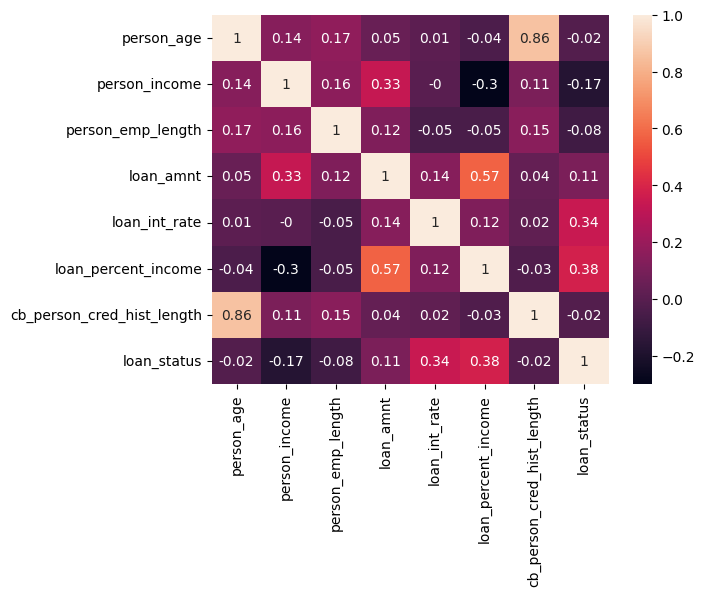

In [ ]:
num_df = train_data.select_dtypes(include=np.number)

cor = num_df.corr()

sns.heatmap(cor.round(2), annot=True)
plt.show()

In [ ]:
cor["loan_status"].sort_values(ascending=False)

loan_status                   1.000000
loan_percent_income           0.378632
loan_int_rate                 0.336425
loan_amnt                     0.105504
cb_person_cred_hist_length   -0.016570
person_age                   -0.019955
person_emp_length            -0.079182
person_income                -0.171328
Name: loan_status, dtype: float64

`loan_int_rate` and `loan_percent_income` have shown a slight correlation in with our target variable. Lets investigate this feature further in the EDA.

## Overview all input variables

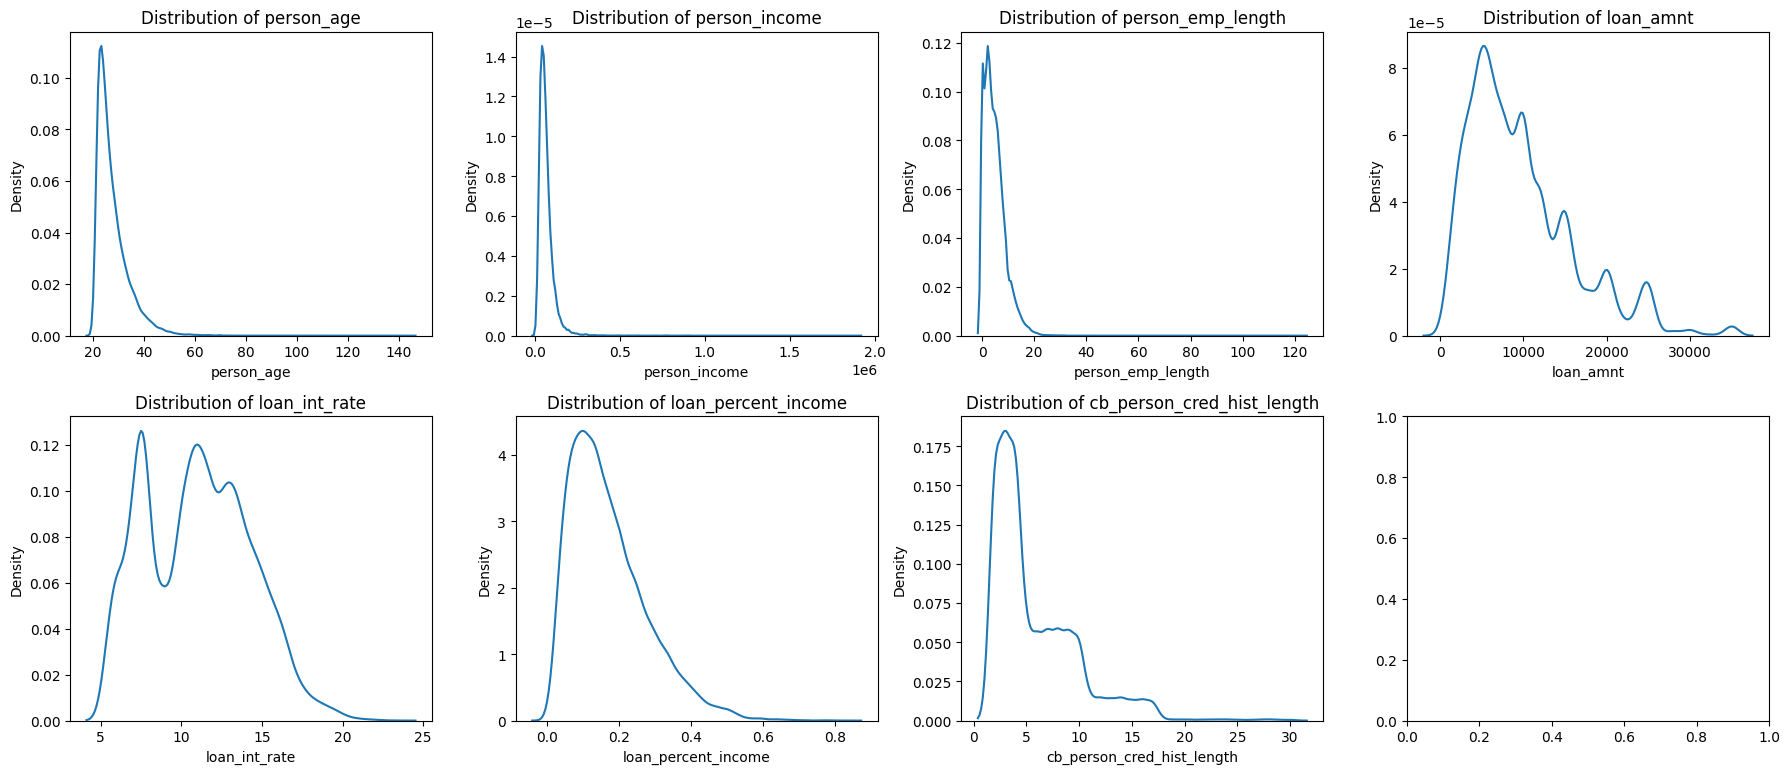

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = ax.flatten()

for i, col in enumerate(X_train_num.columns):
    sns.kdeplot(X_train_num[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

<ipython-input-386-f6af88ea18f9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels())
<ipython-input-386-f6af88ea18f9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels())
<ipython-input-386-f6af88ea18f9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels())


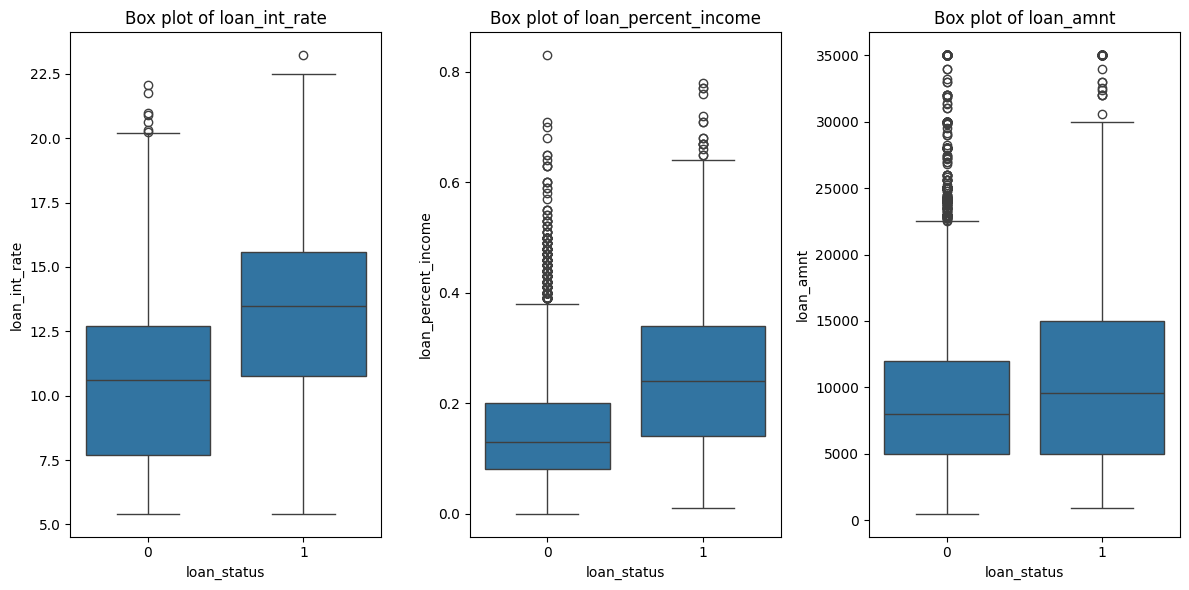

In [ ]:
cols = ["loan_int_rate", "loan_percent_income", "loan_amnt"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

for i, col in enumerate(cols):
  sns.boxplot(data=train_data, x="loan_status", y=col, ax=axes[i])
  axes[i].set_xticklabels(axes[i].get_xticklabels())
  axes[i].set_title(f"Box plot of {col}")

plt.tight_layout()
plt.show()

**Insights:**

- The first two variables revealed a pattern that default users might be affected by high interest rate and have a higher loan income ratio than non-default user

- Both of these assumptions appear logical. The higher the loan-to-income ratio an applicant possesses, the lesser their disposable income becomes. This prompts the applicant to reevaluate their needs resulting in an higher awareness towards their financial management. However, this might not be the case for everyone as they have different financial background and knowledge.

- The same goes for `loan_int_rate`. High interest rate means cutback on one's disposable income. However, interest rate is usually a long term payment which can fluctuates depending on other economic factors. During years with inflated market (e.g: high-inflation) government might be incline to hike the interest rate and in reverse, cuts rates when the economy looks weak (high unemployment). Furthermore, this predictor may have different value depending on the loan intention.

### 1.3.1 Applicant Age - `person_age`

In [ ]:
train_data["person_age"].value_counts().sort_index(ascending=True).tail(10)

person_age
65     6
66     7
69     4
70     7
73     3
76     1
78     1
80     1
123    2
144    1
Name: count, dtype: int64

In [ ]:
train_data["person_age"].value_counts().sort_index(ascending=True).head(5)

person_age
20      13
21     977
22    2911
23    3108
24    2821
Name: count, dtype: int64

In [ ]:
test_1 = train_data.query("person_age > 100")
test_1

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4,0


As per common parameters for age filtering requires a person to be at legal age(> 18). Eventough there are no age limitation to take loans, four data points suggest there are 4 applicants with age > 100. we can set the 100 y.o. mark as maximum threshold for loan application

In [ ]:
query_1 = train_data.query("person_age < 100")
query_1

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0
32528,65,120000,MORTGAGE,0.0,PERSONAL,B,12000,11.48,0.10,N,21,0
9239,26,24000,RENT,0.0,VENTURE,A,5000,8.90,0.21,N,2,0
6952,25,50400,MORTGAGE,NaN,HOMEIMPROVEMENT,A,6000,7.14,0.12,N,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32519,51,115900,MORTGAGE,16.0,PERSONAL,A,12000,7.88,0.10,N,29,0
27774,29,200000,MORTGAGE,9.0,MEDICAL,B,6000,NaN,0.03,N,8,0
16720,25,30000,RENT,9.0,VENTURE,D,9000,17.58,0.30,N,2,0
90,22,240000,OWN,6.0,PERSONAL,B,25000,NaN,0.10,N,2,0


### 1.3.2 Loan Interest Rate - `loan_int_rate`

<Axes: xlabel='loan_intent', ylabel='loan_int_rate'>

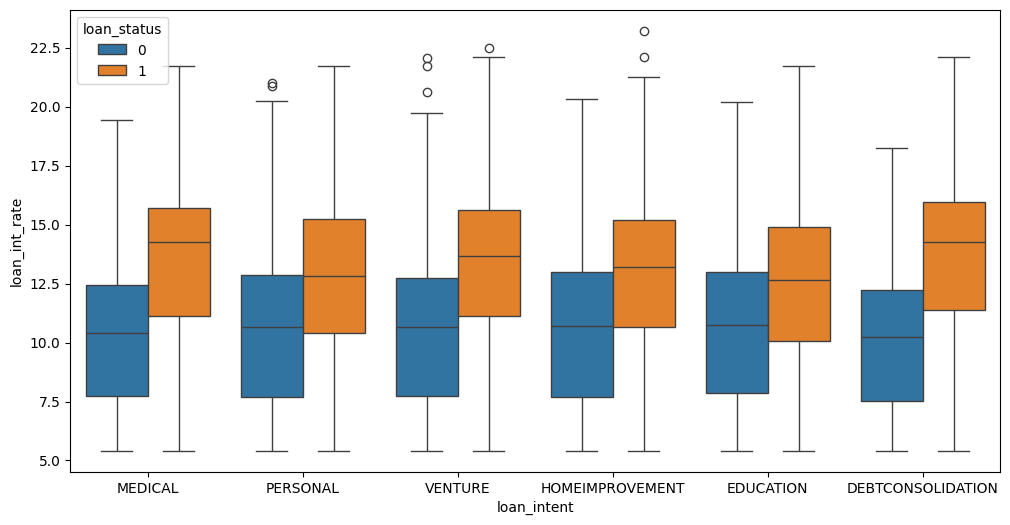

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=query_1, x="loan_intent", y="loan_int_rate", hue="loan_status")




*   Surprisingly there are no significant difference between interest rate for different loan intention which leads to  minimal outliers.

*   Normally this variable can not have empty value nor it will be 0 due to the nature of a loan and economoical situation which determines the interest rate for a loan.

* Therefore its important to drop rows that have missing value in this variables.





In [ ]:
idx_intRate_miss = query_1[query_1["loan_int_rate"].isnull()].index.to_list()
print(len(idx_intRate_miss))

2463


In [ ]:
query_2 = query_1.drop(idx_intRate_miss)
print(len(query_1))
print(len(query_2))

25929
23466


### Employment Length - `person_emp_length`

In [ ]:
empLeng_missing_count = query_1["person_emp_length"].isna().sum()
print(f"Ratio of missing count: {round(empLeng_missing_count / len(query_1['person_emp_length']), 2)} with : {empLeng_missing_count} missing values")

Ratio of missing count: 0.03 with : 707 missing values


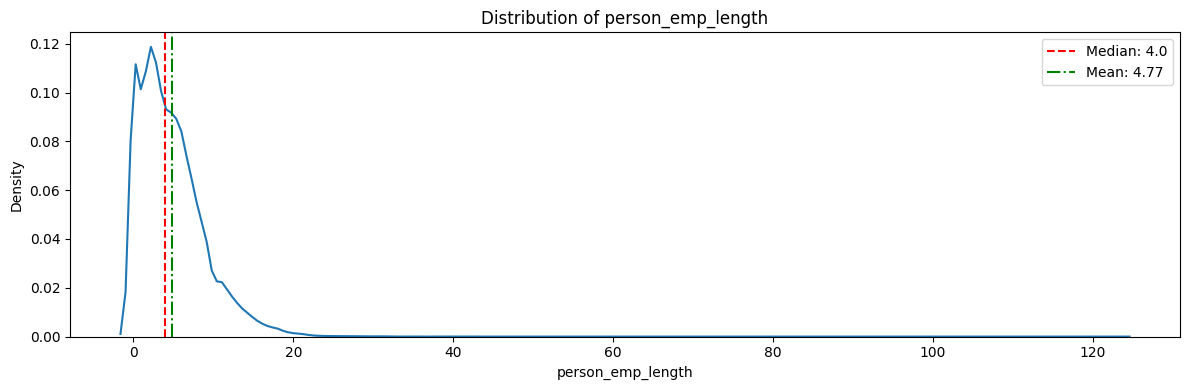

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

# plot for person_emp_length
sns.kdeplot(X_train_num["person_emp_length"], ax=ax)
ax.set_title('Distribution of person_emp_length')

## add median line and legend in the plot
idx_med = X_train_num["person_emp_length"].median()
idx_avg = X_train_num["person_emp_length"].mean()

ax.axvline(x=idx_med, color='r', linestyle='--', label='Median: ' + str(round(idx_med, 2)))
ax.axvline(x=idx_avg, color='g', linestyle='-.', label='Mean: ' + str(round(idx_avg, 2)))
ax.legend()

plt.tight_layout()
plt.show()

this variable is  tail heavy which might have errors in them (i.e: there are people with > 40 years of employment). Normally, people have a career between 20-40 years before retirement age. we have to investigate this anomaly further.

In [ ]:
head_emp = query_1["person_emp_length"].value_counts().sort_index(ascending=False).head(5)
tail_emp = query_1["person_emp_length"].value_counts().sort_index(ascending=False).tail(5)

df_emp_leng = pd.concat([head_emp, tail_emp], axis=0)
df_emp_leng

person_emp_length
123.0       1
41.0        1
38.0        1
34.0        1
31.0        3
4.0      2273
3.0      2782
2.0      3124
1.0      2299
0.0      3254
Name: count, dtype: int64

In [ ]:
train_data.query("person_emp_length == 123")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1


From this investigation, this data is impossible because **the applicant is only 22 yo with 123 years of working experience**. we can remove this one.

It would also be beneficial when the input is filtered from anomalous data where `person_emp_length` is bigger than `person_age`. additionally, We can use the common career trajectory to create a threshold for anomalous data.

This consideration considers **minimum ratio of age-employment** ratio i.e: maximum age of first employment and** maximum age-employment ratio** a person can legally reach. The calculation is illustrated below:

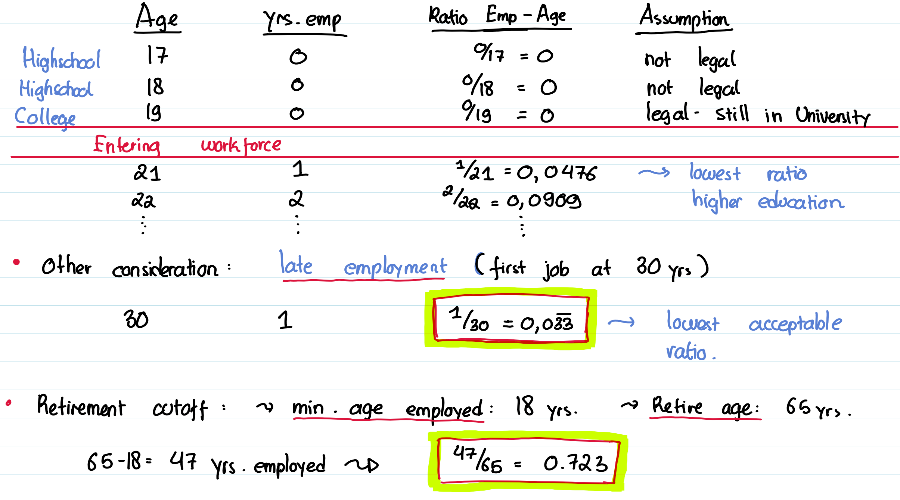

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

path = "/content/image (1).png"
EmpAgeRatio = cv.imread(path)
down_width = 900
down_height = 500
down_points = (down_width, down_height)
resized_down = cv.resize(EmpAgeRatio, down_points, interpolation= cv.INTER_LINEAR)

cv2_imshow(resized_down)

from the calculation there are two threshold which shows the maximum and minimum of age-employment ratio.

1. The minimum ratio implies that the maximum risk our bank can accept is a working class person who started their carrer at 30 years old. This consideration is made due to the dynamic nature of rising unemployment rate amongst youth and graduates.

2. The maximum ratio implies that the minimal risk our bank can accept is a working class person who started their carrer early on at 18 y.o (minimum legal age). This consideration takes into account applicant who have started their carrer right after highschool and continous to work until the retirement age.

3. The ratio in between captures the dynamic of the job market where person can be employed and have a carrer break or started late.

4. The ratio outside of the threshold indicates that applicant may have not sufficient means of income history or fallen out of job market. Here are coverage example of some unsual cases that this consideration handles:

  - Applicant works at the early age of 18 then stopped working at 22 due to disabilities, then at the age of 56 they apply for medical loan.
  Ratio = 4 / 56 --> 0.07 *still eligible for loan*

  - exceeding this maximum ratio means incorect data was collected or applicant may worked more than its legally allowed

Eventough this approach is a good filter for input data, it **will remove some applicant that do not have employment history** but able to finance their loan through other means (i.e: P2P-Lending, Secured Loans, Guarantor Loans, etc.).

Since there are no more information of which kind of loan is given nor the source of income the applicant has. This measures provide a good safe guarding techniques with the limited information available.



**Outlier detection from actual dataset**

In [ ]:
query_2a = deepcopy(query_2)
query_2a["ratio_emp_age"] = query_2a["person_emp_length"] / query_2a["person_age"]

In [ ]:
query_22 = query_2a[(query_2a["ratio_emp_age"] > 0.0333) & (query_2a["ratio_emp_age"] < 0.723)]
query_22["ratio_emp_age"].describe().round(2)


count    19432.00
mean         0.20
std          0.12
min          0.03
25%          0.09
50%          0.18
75%          0.30
max          0.72
Name: ratio_emp_age, dtype: float64

we have cut roughly 4000 Observations from our dataset that detected as anomalous from employment-age ratio. This dataset then can be considered as machine learning algorithm **that classify loan default perdiction for common working indviduals.**

#### Person_Income

In [ ]:
query_22["person_income"].describe().round(2)

count      19432.00
mean       67777.01
std        50795.15
min         4200.00
25%        40000.00
50%        57323.50
75%        80000.00
max      1440000.00
Name: person_income, dtype: float64

we see the max income shown at \$1.9 Million which can be considered too much for working class individual. The highest management position in a company someone can earn is the Chief Executife Office outside BOD / Chair which are not considered in this model. According to Glassdoor a CEO on average can earn between $305K - $570K / year.

lets set the scale into **$500K / year as our cut off value.**

Glassdoor: https://www.glassdoor.com/Salaries/los-angeles-ceo-salary-SRCH_IL.0,11_IM508_KO12,15.htm?countryRedirect=true&countryPickerRedirect=true

In [ ]:
query_23a = query_22.query("person_income < 500000")
query_23 = deepcopy(query_23a)

In [ ]:
# lets see how many applicants that have a salary below and above 1Q and 3Q
limit_1 = query_23[(query_23["person_income"] < 40e3) | (query_23["person_income"] > 80e3)]
limit_1.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,ratio_emp_age
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1,0.238095
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0,0.178571
1656,21,12000,RENT,3.0,EDUCATION,B,1600,10.59,0.13,N,2,1,0.142857
15642,24,150000,MORTGAGE,2.0,PERSONAL,B,24250,10.38,0.16,N,3,0,0.083333
4362,22,21000,RENT,5.0,MEDICAL,B,4800,10.75,0.23,N,3,0,0.227273


In [ ]:
ratio = limit_1.shape[0] / query_23.shape[0]
print(ratio)

0.4862342751082697


Due to the high ratio of observations that contain personal income higher or lower than the outlier threshold (1st and 3rd IQR). We can not directly remove the observations solely due to it being anomalous, plus we already have another predictor tied to personal income that has a high linear correlation with the target variabel.

Might be better if we could engineer this features to describe their relationship to the target variables better. One suggestion is to categorize the income based on the salary range. Using the quartile range, we ended up with 5 groups of income level:



```
RANGE             Mid of class        LEVEL          NUMERIC
-----             --------         --------        ---------
$ 0 - 4200        $ 2000           Lowest           10

$ 4201 - 40_800   $ 21250          Low              8.4

$ 40_801 - 58_000 $ 46750          Middle           6.3

$ 58501 - 80_500  $ 67100          High             4.6

$ 80_500 - 500K   $ 122612         Highest          1
```

This is an ordinal categorical problem. The numeric value suggest the middle point of the salary class range. since the range from each class is different we set up the maximum and minimum value of the ordinal range from 1-10. Then we set the middle point of the lowest class to be encoded as the 10th value and the middle point of the highest class to be the 1st value. other classes follows the 1-10 scale proportionately as the ratio.

In [ ]:
def categorize_income(income):
    if income < 4200:
        return 'lowest'
    elif 4200 <= income < 40_800:
        return 'low'
    elif 40_800 <= income < 58_000:
        return 'middle'
    elif 58_000 <= income < 80_500:
        return 'high'
    else:
        return 'highest'

#query_21.drop(columns={"income_category"}, inplace=True)
query_23['income_category'] = query_23['person_income'].apply(categorize_income)
query_23['income_category'].value_counts()

income_category
low        5058
high       4839
middle     4750
highest    4749
Name: count, dtype: int64

In [ ]:
query_23.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,ratio_emp_age,income_category
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1,0.238095,low
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0,0.178571,highest
3643,23,69000,RENT,4.0,EDUCATION,D,3800,15.28,0.06,Y,3,1,0.173913,high
1656,21,12000,RENT,3.0,EDUCATION,B,1600,10.59,0.13,N,2,1,0.142857,low
15642,24,150000,MORTGAGE,2.0,PERSONAL,B,24250,10.38,0.16,N,3,0,0.083333,highest


Since this is an ordinal categorical variable, we need to have some additional preprocessing step which mapped the income level based on the distance between income level.

we use the middle point of each income level to scale the variable in numerical. The lowest value of the scale indicate by the middle point of lowest income and the highest point is indicated by the middle point of the highest income group. Below is the calculation for each middle point:

In [ ]:
### Attribute of income limit
mid_lowest = ((4200-0)/2) + 0
mid_low = ((40_800-4201)/2) + 4201
mid_middle = ((58_000-40_801)/2) + 40_801
mid_high = ((80_500-58_001)/2) + 58_001
mid_highest = ((query_23["person_income"].max() - 81001)/2) + 81001
list_of_mid_class = [mid_lowest, mid_low, mid_middle, mid_high, mid_highest]

for idx in list_of_mid_class:
  print(idx)

2100.0
22500.5
49400.5
69250.5
280500.5


In [ ]:
def rescale(salary, data_cols, scale_min, scale_max):
    min_value = data_cols.min() ; max_value = data_cols.max()
    return round(scale_max - (((salary - 2100) / (280500 - 2100)) * (scale_max - scale_min)),2)

rescaled_lowest = rescale(mid_lowest, query_23["person_income"], 1, 10)
rescaled_low = rescale(mid_low, query_23["person_income"], 1, 10)
rescaled_middle = rescale(mid_middle, query_23["person_income"], 1, 10)
rescaled_high = rescale(mid_high, query_23["person_income"], 1, 10)
rescaled_highest = rescale(mid_highest, query_23["person_income"], 1, 10)

list_of_new_scale = [rescaled_lowest, rescaled_low, rescaled_middle, rescaled_high, rescaled_highest]
list_of_income_level = ["lowest","low","middle","high","highest"]
Scaler_DF = pd.DataFrame({
    "income_level": list_of_income_level,
    "class_average":list_of_mid_class,
    "new_scale":list_of_new_scale
}
                         )

Scaler_DF

,income_level,class_average,new_scale
0,lowest,2100.0,10.00
1,low,22500.5,9.34
2,middle,49400.5,8.47
3,high,69250.5,7.83
4,highest,280500.5,1.00


In [ ]:
income_dict = dict(zip(list_of_income_level, list_of_new_scale))
income_dict

{'lowest': 10.0, 'low': 9.34, 'middle': 8.47, 'high': 7.83, 'highest': 1.0}

In [ ]:
query_23['cat_ordinal_income'] = query_23['income_category'].map(income_dict)
query_23

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,ratio_emp_age,income_category,cat_ordinal_income
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1,0.238095,low,9.34
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0,0.178571,highest,1.00
3643,23,69000,RENT,4.0,EDUCATION,D,3800,15.28,0.06,Y,3,1,0.173913,high,7.83
1656,21,12000,RENT,3.0,EDUCATION,B,1600,10.59,0.13,N,2,1,0.142857,low,9.34
15642,24,150000,MORTGAGE,2.0,PERSONAL,B,24250,10.38,0.16,N,3,0,0.083333,highest,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23281,34,61000,OWN,7.0,VENTURE,A,5000,5.42,0.08,N,6,0,0.205882,high,7.83
7539,24,53800,MORTGAGE,4.0,DEBTCONSOLIDATION,B,6000,10.99,0.11,N,2,0,0.166667,middle,8.47
13089,23,91392,RENT,7.0,DEBTCONSOLIDATION,A,12000,5.42,0.13,N,3,0,0.304348,highest,1.00
32519,51,115900,MORTGAGE,16.0,PERSONAL,A,12000,7.88,0.10,N,29,0,0.313725,highest,1.00


**we can create a class to define income level**

In [ ]:
class DefineIncome:
    """
    The DefineIncome class is designed to categorize and rescale personal incomes.

    Attributes:
    query: The input DataFrame containing a 'person_income' column.
    """
    def __init__(self, query):
        self.query = deepcopy(query)

    def categorize_income(self, income):
        """
        The function to categorize incomes into 'lowest', 'low', 'middle', 'high', and 'highest'.

        Parameters:
        income (int or float): The personal income.

        Returns:
        str: The income category.
        """
        if income < 4200:
            return 'lowest'
        elif 4200 <= income < 40_800:
            return 'low'
        elif 40_800 <= income < 58_000:
            return 'middle'
        elif 58_000 <= income < 80_500:
            return 'high'
        else:
            return 'highest'

    def new_columns_and_df(self):
        """
        The function to apply categorize_income to 'person_income' and rescale the middle value
        of each category over a new scale.

        Returns:
        pd.DataFrame: The updated DataFrame with a new 'income_category' column.
        pd.DataFrame: The DataFrame that includes 'income_level', 'class_average', and 'new_scale'.
        """
        self.query['income_category'] = self.query['person_income'].apply(self.categorize_income)
        mid_values = [(self.query[self.query['income_category'] == lvl]['person_income'].min()
                      + self.query[self.query['income_category'] == lvl]['person_income'].max()) / 2
                      for lvl in ['lowest', 'low', 'middle', 'high', 'highest']]

        def rescale(value, series, scale_min, scale_max):
            min_value = series.min()
            max_value = series.max()
            rescaled = round(scale_max - (
                (value - min_value) / (max_value - min_value)) * (scale_max - scale_min), 2)
            return rescaled

        rescaled_values = [rescale(val, self.query['person_income'], 1, 10) for val in mid_values]

        scaler_df = pd.DataFrame({
            "income_level": ['lowest', 'low', 'middle', 'high', 'highest'],
            "class_average": mid_values,
            "new_scale": rescaled_values
        })

        return self.query, scaler_df



In [ ]:
Income_class = DefineIncome(query_23)

query_24, Scaler_DF = Income_class.new_columns_and_df()

In [ ]:
query_24

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,ratio_emp_age,income_category,cat_ordinal_income
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1,0.238095,low,9.34
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0,0.178571,highest,1.00
3643,23,69000,RENT,4.0,EDUCATION,D,3800,15.28,0.06,Y,3,1,0.173913,high,7.83
1656,21,12000,RENT,3.0,EDUCATION,B,1600,10.59,0.13,N,2,1,0.142857,low,9.34
15642,24,150000,MORTGAGE,2.0,PERSONAL,B,24250,10.38,0.16,N,3,0,0.083333,highest,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23281,34,61000,OWN,7.0,VENTURE,A,5000,5.42,0.08,N,6,0,0.205882,high,7.83
7539,24,53800,MORTGAGE,4.0,DEBTCONSOLIDATION,B,6000,10.99,0.11,N,2,0,0.166667,middle,8.47
13089,23,91392,RENT,7.0,DEBTCONSOLIDATION,A,12000,5.42,0.13,N,3,0,0.304348,highest,1.00
32519,51,115900,MORTGAGE,16.0,PERSONAL,A,12000,7.88,0.10,N,29,0,0.313725,highest,1.00


#### Home Ownership  // `person_home_ownership`

In [ ]:
query_22["person_home_ownership"].value_counts()

person_home_ownership
RENT        9441
MORTGAGE    8438
OWN         1491
OTHER         62
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

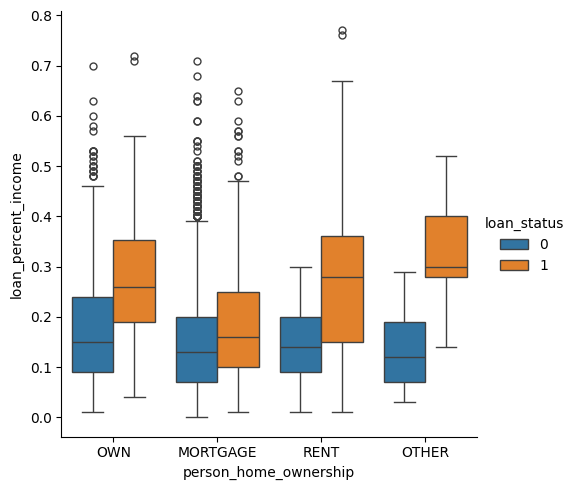

In [ ]:
plt.figure(figsize=(12,6))
sns.catplot(data=query_22, x="person_home_ownership", y="loan_percent_income", hue="loan_status", kind="box")

Theres is nothing to preprocess for this category

### Loan intention // `loan_intent`

In [ ]:
query_22["loan_intent"].value_counts()

loan_intent
EDUCATION            3853
MEDICAL              3566
VENTURE              3438
PERSONAL             3345
DEBTCONSOLIDATION    3059
HOMEIMPROVEMENT      2171
Name: count, dtype: int64

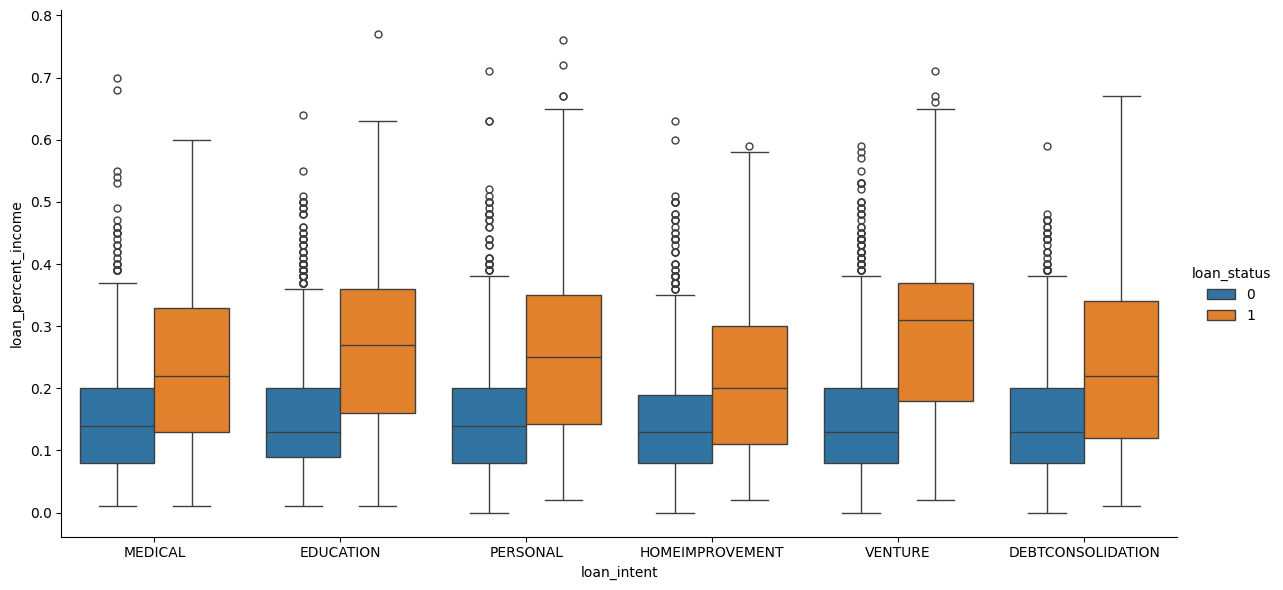

In [ ]:
sns.catplot(data=query_22, x="loan_intent", y="loan_percent_income",
            hue="loan_status", kind="box", height=6, aspect=2)

In [ ]:
query_22

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,ratio_emp_age
30,21,11520,OWN,5.0,MEDICAL,B,2000,11.12,0.17,N,3,1,0.238095
25196,28,80748,MORTGAGE,5.0,MEDICAL,A,5000,7.51,0.06,N,9,0,0.178571
3643,23,69000,RENT,4.0,EDUCATION,D,3800,15.28,0.06,Y,3,1,0.173913
1656,21,12000,RENT,3.0,EDUCATION,B,1600,10.59,0.13,N,2,1,0.142857
15642,24,150000,MORTGAGE,2.0,PERSONAL,B,24250,10.38,0.16,N,3,0,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23281,34,61000,OWN,7.0,VENTURE,A,5000,5.42,0.08,N,6,0,0.205882
7539,24,53800,MORTGAGE,4.0,DEBTCONSOLIDATION,B,6000,10.99,0.11,N,2,0,0.166667
13089,23,91392,RENT,7.0,DEBTCONSOLIDATION,A,12000,5.42,0.13,N,3,0,0.304348
32519,51,115900,MORTGAGE,16.0,PERSONAL,A,12000,7.88,0.10,N,29,0,0.313725


# Pre-Processing & Modelling 1 : With no edits to all data - Baseline Estimate

In [ ]:
#### Dependencies

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from copy import deepcopy


In [ ]:
"speeding" OR "accidents" OR "crash" OR "injuries" AND "speed enforcement" OR "photo enforcement"
OR "photo enforcement" OR "speed limiter"

### Numerical Imputation

In [ ]:
## Functions

def num_imputer_fit(data):
  imputer = SimpleImputer(strategy="median", missing_values=np.nan)
  num_imp = imputer.fit(data)
  return num_imp

def numerical_impute_transform(data, imputer):
  col_number = data.columns
  temp_df = imputer.transform(data)
  end_df = pd.DataFrame(temp_df, columns=col_number, index=data.index)
  return end_df

In [ ]:
num_imputer = num_imputer_fit(X_train_num)

X_train_num_imputed = numerical_impute_transform(X_train_num, num_imputer)

In [ ]:
percent_missing_values(X_train_num_imputed)

0.0% missing values of person_age

0.0% missing values of person_income

0.0% missing values of person_emp_length

0.0% missing values of loan_amnt

0.0% missing values of loan_int_rate

0.0% missing values of loan_percent_income

0.0% missing values of cb_person_cred_hist_length



great!

### Categorical Pre-Processing

In [ ]:
X_train_cat.head(5)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
30,OWN,MEDICAL,B,N
25196,MORTGAGE,MEDICAL,A,N
32528,MORTGAGE,PERSONAL,B,N
9239,RENT,VENTURE,A,N
6952,MORTGAGE,HOMEIMPROVEMENT,A,N



Actions for each categorical value:
*   `person_home_ownership`               : Encoding
*   `loan_intent`                         : Encoding
*   `loan_grade`                          : Ordinal-numbering
*   `cb_person_default_on_file`           : Encoding


Therefore, lets perform ordinal numbering first. Then the rest of non-ordinal categorical features will be encoded simulateously.



#### Loan-Grade Ordinal Numbering

In [ ]:
X_train_cat_LG = X_train_cat["loan_grade"]

X_train_cat.drop("loan_grade", axis=1, inplace=True)

validation

In [ ]:
X_train_cat.head(2)

,person_home_ownership,loan_intent,cb_person_default_on_file
30,OWN,MEDICAL,N
25196,MORTGAGE,MEDICAL,N


In [ ]:
X_train_cat_LG.value_counts()

loan_grade
A    8511
B    8303
C    5201
D    2898
E     773
F     196
G      50
Name: count, dtype: int64

In [ ]:
grade_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G":7}

X_train_cat_LG = X_train_cat_LG.map(grade_mapping)

X_train_cat_LG.value_counts()

loan_grade
1    8511
2    8303
3    5201
4    2898
5     773
6     196
7      50
Name: count, dtype: int64

This Series will be joined later with other input variables


#### Encoding

In [ ]:
def cat_encoder_fit(data):
    # Create an encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the data
    encoder.fit(data)

    return encoder

def cat_encoder_transform(data, encoder):
  # Transform the data using the fitted encoder
  encoded = encoder.transform(data)

  # Get feature names from the encoder and use as columns
  encoded_data = pd.DataFrame(encoded,
                              columns=encoder.get_feature_names_out(
                                  input_features=data.columns),
                              index=data.index)

  return encoded_data

In [ ]:
cat_encoder = cat_encoder_fit(X_train_cat)

X_train_cat_encoded = cat_encoder_transform(X_train_cat, cat_encoder)

In [ ]:
X_train_cat_encoded.head(5)

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
25196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9239,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6952,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


lets join all data together



In [ ]:
complete_df = pd.concat([X_train_num_imputed, X_train_cat_LG, X_train_cat_encoded], axis=1)

In [ ]:
complete_df.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
30,21.0,11520.0,5.0,2000.0,11.12,0.17,3.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
25196,28.0,80748.0,5.0,5000.0,7.51,0.06,9.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32528,65.0,120000.0,0.0,12000.0,11.48,0.10,21.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9239,26.0,24000.0,0.0,5000.0,8.90,0.21,2.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6952,25.0,50400.0,4.0,6000.0,7.14,0.12,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
percent_missing_values(complete_df)

0.0% missing values of person_age

0.0% missing values of person_income

0.0% missing values of person_emp_length

0.0% missing values of loan_amnt

0.0% missing values of loan_int_rate

0.0% missing values of loan_percent_income

0.0% missing values of cb_person_cred_hist_length

0.0% missing values of loan_grade

0.0% missing values of person_home_ownership_MORTGAGE

0.0% missing values of person_home_ownership_OTHER

0.0% missing values of person_home_ownership_OWN

0.0% missing values of person_home_ownership_RENT

0.0% missing values of loan_intent_DEBTCONSOLIDATION

0.0% missing values of loan_intent_EDUCATION

0.0% missing values of loan_intent_HOMEIMPROVEMENT

0.0% missing values of loan_intent_MEDICAL

0.0% missing values of loan_intent_PERSONAL

0.0% missing values of loan_intent_VENTURE

0.0% missing values of cb_person_default_on_file_N

0.0% missing values of cb_person_default_on_file_Y



In [ ]:
complete_df.duplicated().sum()

0

#### Scaling the data

In [ ]:
def fit_scaler(data):
  scaler = StandardScaler()

  std_scaler = scaler.fit(data)

  return std_scaler


def transform_scaler(data, scaler):
    scaled_data = scaler.transform(data)

    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

    return scaled_df

In [ ]:
scaler = fit_scaler(complete_df)

X_train_clean = transform_scaler(complete_df, scaler=scaler)

## Pre-Processing Step

In [ ]:
print(X_valid.shape)
print(X_test.shape)

(3242, 11)
(3242, 11)


In [ ]:
def preprocess_data(data, encoder, num_imputer, cat_cols, LG_cols, num_cols, scaler, mapper):
  data_1 = deepcopy(data)
  df_num = data_1[num_cols] ; df_cat = data_1[cat_cols] ; df_LG = data_1[LG_cols]

  ## numerical imputation
  df_num_imputed = numerical_impute_transform(df_num, num_imputer)

  ## categorical mapping
  df_lg_mapped = df_LG.map(mapper)

  ## fitting cat encoder
  cat_encoder = cat_encoder_fit(df_cat)

  ## categorical encoding
  df_cat_encoded = cat_encoder.transform(df_cat)

  # Get feature names from the encoder and use as columns
  encoded_data = pd.DataFrame(df_cat_encoded,
                              columns=encoder.get_feature_names_out(
                                  input_features=df_cat.columns),
                              index=df_cat.index)

  # join all series / dataframe
  joined_df = pd.concat([df_num_imputed, df_lg_mapped, encoded_data], axis=1)

  # scale data
  df_clean = transform_scaler(joined_df, scaler=scaler)

  print(f"Data before pre-process: {data_1.shape}")
  print(f"Data before pre-process: {df_clean.shape}")

  return df_clean

In [ ]:
num_colsTR = X_train_num.columns

In [ ]:
cat_colsTR = X_train_cat.columns

In [ ]:
LG_cols = "loan_grade"

In [ ]:
def preprocess_data_test(data, cat_cols, LG_cols, num_cols, num_imputer, mapper):
  data_1 = deepcopy(data)
  df_num = data_1[num_cols] ; df_cat = data_1[cat_cols] ; df_LG = data_1[LG_cols]

  ## numerical imputation
  df_num_imputed = numerical_impute_transform(df_num, num_imputer)

  ## categorical mapping
  df_lg_mapped = df_LG.map(mapper)

  ## fitting cat encoder
  cat_encoder = cat_encoder_fit(df_cat)

  ## categorical encoding
  df_cat_encoded = cat_encoder.transform(df_cat)

  # Get feature names from the encoder and use as columns
  encoded_data = pd.DataFrame(df_cat_encoded,
                              columns=cat_encoder.get_feature_names_out(
                                  input_features=df_cat.columns),
                              index=df_cat.index)

  # join all series / dataframe
  joined_df = pd.concat([df_num_imputed, encoded_data, df_lg_mapped], axis=1)

  # scale data
  #df_clean = transform_scaler(joined_df, scaler=scaler)

  print(f"Data before pre-process: {data_1.shape}")
  #print(f"Data before pre-process: {df_clean.shape}")

  return df_num, df_cat, df_LG, df_num_imputed, df_lg_mapped, encoded_data, joined_df

In [ ]:
X_valid_clean = preprocess_data(
    data = X_valid,
    encoder = cat_encoder,
    num_imputer = num_imputer,
    cat_cols = cat_colsTR,
    LG_cols = LG_cols,
    num_cols = num_colsTR,
    scaler = scaler,
    mapper = grade_mapping
)

Data before pre-process: (3242, 11)
Data before pre-process: (3242, 20)


In [ ]:
X_test_clean = preprocess_data(
    data = X_test,
    encoder = cat_encoder,
    num_imputer = num_imputer,
    cat_cols = cat_colsTR,
    LG_cols = LG_cols,
    num_cols = num_colsTR,
    scaler = scaler,
    mapper = grade_mapping
)

Data before pre-process: (3242, 11)
Data before pre-process: (3242, 20)


In [ ]:
X_train_clean.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00,25932.00
mean,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.23,-1.21,-1.18,-1.44,-1.82,-1.60,-0.94,-1.05,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,-2.15,-0.47
25%,-0.75,-0.54,-0.68,-0.73,-0.82,-0.75,-0.69,-1.05,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
50%,-0.27,-0.21,-0.19,-0.25,-0.01,-0.19,-0.44,-0.19,-0.83,-0.06,-0.29,0.99,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
75%,0.36,0.26,0.56,0.44,0.69,0.56,0.55,0.66,1.20,-0.06,-0.29,0.99,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
max,18.49,35.77,29.28,4.02,3.95,6.19,5.99,4.09,1.20,17.44,3.40,0.99,2.30,2.01,2.83,2.10,2.20,2.17,0.47,2.15


In [ ]:
X_valid_clean.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00
mean,0.00,0.01,0.03,-0.02,-0.04,-0.02,0.02,-0.03,0.02,-0.02,-0.01,-0.01,0.02,-0.03,-0.02,0.05,-0.02,-0.01,0.03,-0.03
std,0.97,1.17,1.12,1.01,0.99,1.01,1.00,0.99,1.00,0.81,0.99,1.00,1.01,0.98,0.98,1.04,0.99,0.99,0.97,0.97
min,-1.23,-1.17,-1.18,-1.44,-1.82,-1.60,-0.94,-1.05,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,-2.15,-0.47
25%,-0.75,-0.52,-0.68,-0.73,-0.98,-0.75,-0.69,-1.05,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
50%,-0.27,-0.20,-0.19,-0.25,-0.01,-0.19,-0.44,-0.19,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
75%,0.36,0.28,0.56,0.38,0.63,0.47,0.55,0.66,1.20,-0.06,-0.29,0.99,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
max,6.56,38.50,29.28,4.02,3.34,4.87,5.99,4.09,1.20,17.44,3.40,0.99,2.30,2.01,2.83,2.10,2.20,2.17,0.47,2.15


In [ ]:
X_test_clean.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00,3242.00
mean,0.04,0.04,0.01,0.01,-0.02,0.01,0.03,-0.01,0.01,0.02,-0.01,-0.01,0.01,0.01,0.01,-0.01,-0.02,0.00,-0.00,0.00
std,1.12,2.29,1.01,0.99,0.99,1.01,1.04,1.01,1.00,1.15,0.99,1.00,1.01,1.00,1.01,0.99,0.99,1.00,1.00,1.00
min,-1.07,-1.19,-1.18,-1.41,-1.82,-1.60,-0.94,-1.05,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,-2.15,-0.47
25%,-0.75,-0.51,-0.68,-0.73,-0.87,-0.75,-0.69,-1.05,-0.83,-0.06,-0.29,-1.01,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
50%,-0.27,-0.19,-0.19,-0.25,-0.01,-0.19,-0.44,-0.19,-0.83,-0.06,-0.29,0.99,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
75%,0.36,0.24,0.56,0.38,0.66,0.56,0.55,0.66,1.20,-0.06,-0.29,0.99,-0.43,-0.50,-0.35,-0.48,-0.45,-0.46,0.47,-0.47
max,18.49,115.73,6.50,4.02,3.47,4.97,5.99,4.09,1.20,17.44,3.40,0.99,2.30,2.01,2.83,2.10,2.20,2.17,0.47,2.15


## Modeling

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

### Stochastic Gradien Descent

In [ ]:
sgd_clf = SGDClassifier(random_state=123)

sgd_clf.fit(X_train_clean, y_train)

SGDClassifier(random_state=123)

#### Train

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_clean, y_train, cv=5)

cm = confusion_matrix(y_train, y_train_pred)

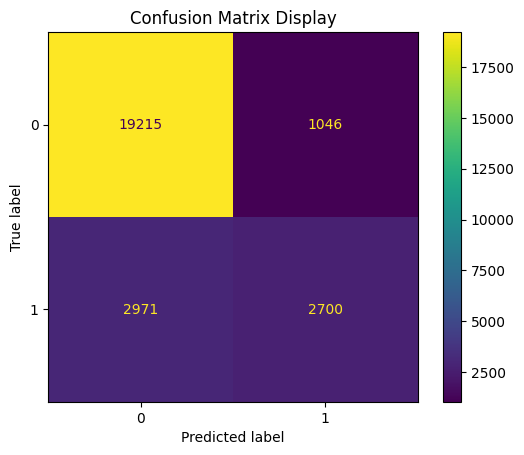

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=sgd_clf.classes_)
disp.plot()
plt.title("Confusion Matrix Display")
plt.show()

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     20261
           1       0.72      0.48      0.57      5671

    accuracy                           0.85     25932
   macro avg       0.79      0.71      0.74     25932
weighted avg       0.83      0.85      0.83     25932



In [ ]:
precision_score(y_train, y_train_pred)

0.7207688200747464

In [ ]:
recall_score(y_train, y_train_pred)

0.47610650678892613

In [ ]:
sgd_clf.fit(X_train_clean, y_train)

y_train_pred_all = sgd_clf.decision_function(X_train_clean)

In [ ]:
precision_train_sgd, recall_train_sgd, threshold = precision_recall_curve(y_train, y_train_pred_all)

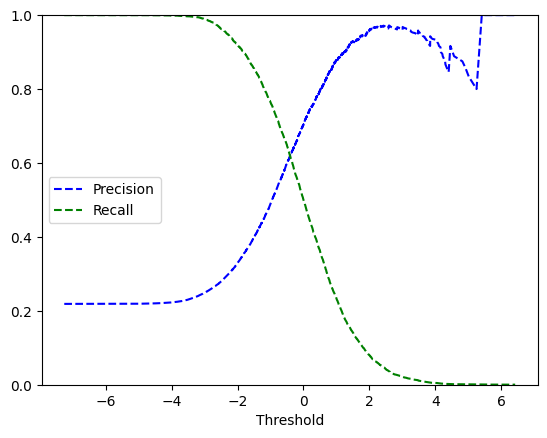

In [ ]:
## plot
plt.plot(threshold, precision_train_sgd[:-1], "b--", label="Precision")
plt.plot(threshold, recall_train_sgd[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.ylim([0,1])
plt.show()

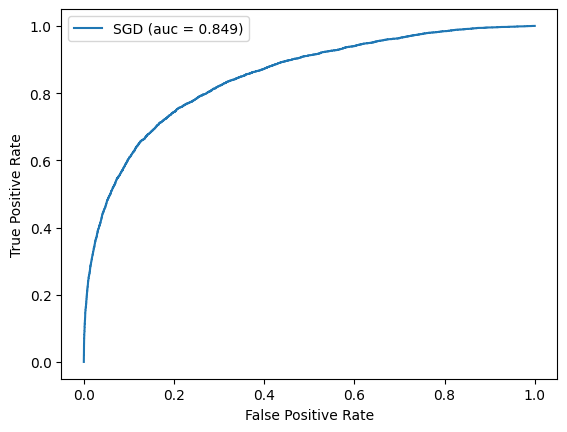

In [ ]:
fpr, tpr, threshold_roc = roc_curve(y_train, y_train_pred_all)
auc_sgd = auc(fpr, tpr)

plt.plot(fpr, tpr, linestyle="-", label="SGD (auc = %0.3f)" % auc_sgd)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

In [ ]:
threshold_roc

array([ 7.42214424,  6.42214424,  5.40869058, ..., -5.43048271,
       -5.440695  , -7.25779889])

#### Valid

In [ ]:
y_valid_pred_SGD = sgd_clf.predict(X_valid_clean)

cm_val_SGD = confusion_matrix(y_valid, y_valid_pred_SGD)

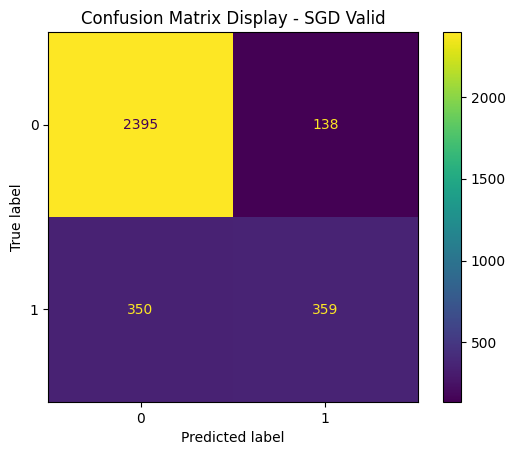

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_SGD,
                               display_labels=sgd_clf.classes_)
disp.plot()
plt.title("Confusion Matrix Display - SGD Valid")
plt.show()

In [ ]:
print(classification_report(y_valid, y_valid_pred_SGD))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2533
           1       0.72      0.51      0.60       709

    accuracy                           0.85      3242
   macro avg       0.80      0.73      0.75      3242
weighted avg       0.84      0.85      0.84      3242



#### Test set

In [ ]:
y_test_pred_SGD = sgd_clf.predict(X_test_clean)

cm_test_SGD = confusion_matrix(y_test, y_test_pred_SGD)

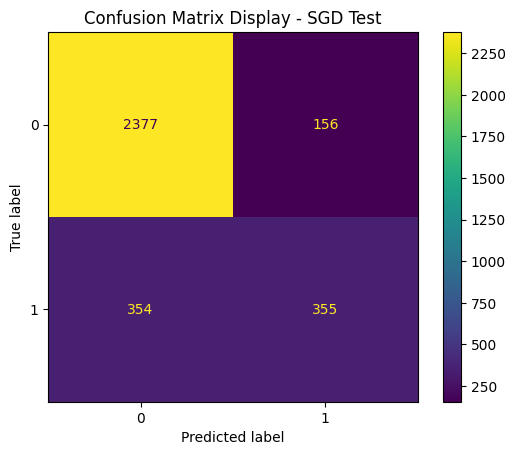

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_SGD,
                               display_labels=sgd_clf.classes_)
disp.plot()
plt.title("Confusion Matrix Display - SGD Test")
plt.show()

In [ ]:
print(classification_report(y_test, y_test_pred_SGD))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2533
           1       0.69      0.50      0.58       709

    accuracy                           0.84      3242
   macro avg       0.78      0.72      0.74      3242
weighted avg       0.83      0.84      0.83      3242



### Log Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lg_clf = LogisticRegression(random_state=123)

lg_clf.fit(X_train_clean, y_train)

LogisticRegression(random_state=123)

In [ ]:
y_train_pred_lg = cross_val_predict(lg_clf, X_train_clean, y_train, cv=5)

cm_lg = confusion_matrix(y_train, y_train_pred_lg)

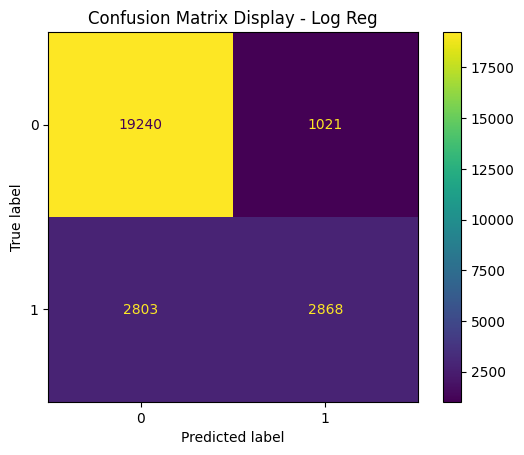

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg,
                               display_labels=lg_clf.classes_)
disp.plot()
plt.title("Confusion Matrix Display - Log Reg")
plt.show()

In [ ]:
print(classification_report(y_train, y_train_pred_lg))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     20261
           1       0.74      0.51      0.60      5671

    accuracy                           0.85     25932
   macro avg       0.81      0.73      0.75     25932
weighted avg       0.84      0.85      0.84     25932



In [ ]:
y_train_pred_lg_decision = lg_clf.decision_function(X_train_clean)

In [ ]:
precision_train_lg, recall_train_lg, threshold_lg_dec = precision_recall_curve(y_train, y_train_pred_lg_decision)

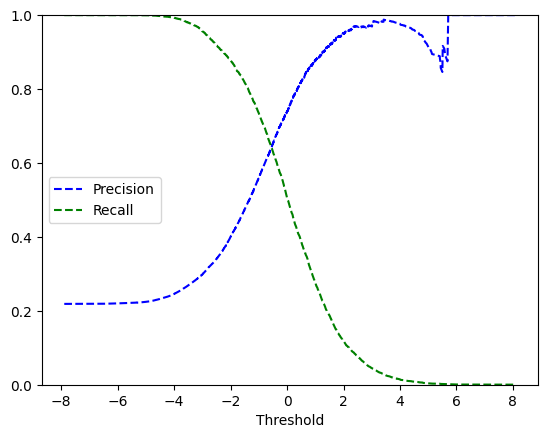

In [ ]:
## plot
plt.plot(threshold_lg_dec, precision_train_lg[:-1], "b--", label="Precision")
plt.plot(threshold_lg_dec, recall_train_lg[:-1], "g--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="center left")
plt.ylim([0,1])
plt.show()

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

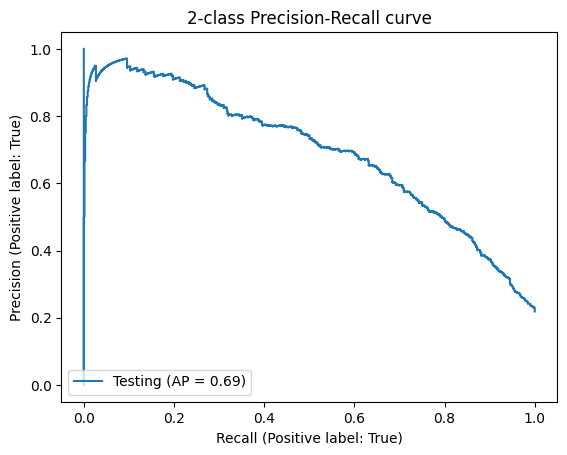

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    lg_clf, X_test_clean, y_test, name="Testing", pos_label=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

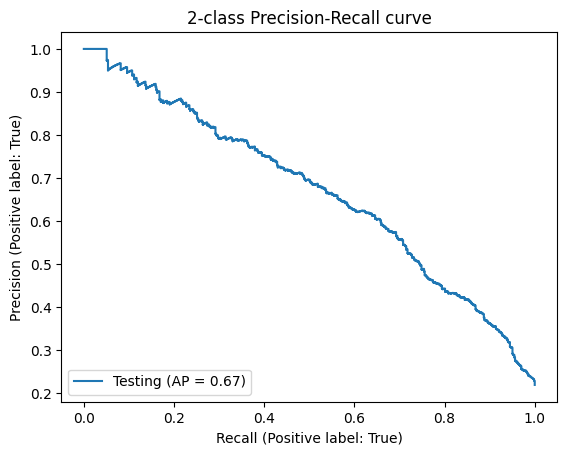

In [ ]:
display_1 = PrecisionRecallDisplay.from_estimator(
    sgd_clf, X_test_clean, y_test, name="Testing", pos_label=True
)
_ = display_1.ax_.set_title("2-class Precision-Recall curve")

valid set

In [ ]:
y_valid_pred_lg = cross_val_predict(lg_clf, X_valid_clean, y_valid, cv=5)

cm_lg = confusion_matrix(y_valid, y_valid_pred_lg)

### XG_boost

In [ ]:
xgb_model = XGBClassifier(objective='binary:logistic')

xgb_model.fit(X_train_clean, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_train_pred_XG = cross_val_predict(xgb_model, X_train_clean, y_train, cv=5)

cm_xgb = confusion_matrix(y_train, y_train_pred_XG)

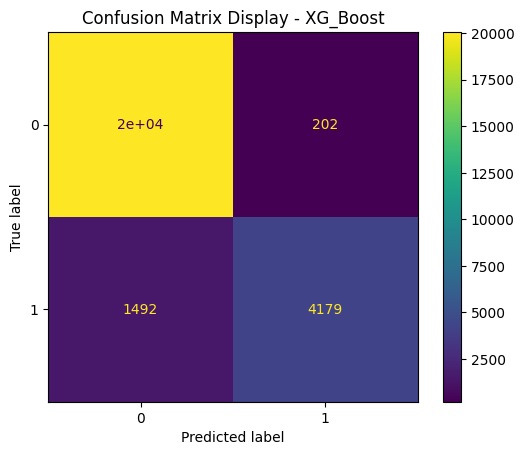

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                               display_labels=xgb_model.classes_)
disp.plot()
plt.title("Confusion Matrix Display - XG_Boost")
plt.show()

In [ ]:
print(classification_report(y_train, y_train_pred_XG))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     20261
           1       0.95      0.74      0.83      5671

    accuracy                           0.93     25932
   macro avg       0.94      0.86      0.90     25932
weighted avg       0.94      0.93      0.93     25932



In [ ]:
y_valid_pred_XG = xgb_model.predict(X_valid_clean)

cm_val_SGD = confusion_matrix(y_valid, y_valid_pred_XG)

In [ ]:
print(classification_report(y_valid, y_valid_pred_XG))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2533
           1       0.95      0.74      0.83       709

    accuracy                           0.93      3242
   macro avg       0.94      0.87      0.90      3242
weighted avg       0.94      0.93      0.93      3242



# Pre-Processing 2: With Preprocessing & Performance Assessment

In [ ]:
#### Dependencies

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from copy import deepcopy


In [ ]:
##### Functions

## Pre-Processing numerical columns

In [ ]:
X_train_num

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
30,21,11520,5.0,2000,11.12,0.17,3
25196,28,80748,5.0,5000,7.51,0.06,9
32528,65,120000,0.0,12000,11.48,0.10,21
9239,26,24000,0.0,5000,8.90,0.21,2
6952,25,50400,NaN,6000,7.14,0.12,4
...,...,...,...,...,...,...,...
32519,51,115900,16.0,12000,7.88,0.10,29
27774,29,200000,9.0,6000,NaN,0.03,8
16720,25,30000,9.0,9000,17.58,0.30,2
90,22,240000,6.0,25000,NaN,0.10,2


In [ ]:
def preprocess_numerical(data, Scaler_DF, income_map):
  ## Limit applicant age
  query_1 = deepcopy(data)
  query_2 = query_1.query("person_age < 100")

  ## drop entries with missing interest rate
  idx_MissIntRate = query_2[query_2["loan_int_rate"].isnull()].index.to_list()
  query_3 = query_2.drop(idx_MissIntRate)

  ## FeatEng - Age & Employment length ratio
  query_3["ratio_emp_age"] = query_3["person_emp_length"] / query_3["person_age"]

  # limit ratio age-emp to low and high threshold
  query_3 = query_3[(query_3["ratio_emp_age"] > 0.0333) & (query_3["ratio_emp_age"] < 0.723)]

  ## FeatEng - categorize income
  Income_class = DefineIncome(query_3)

  # create new columns of income_category and mapped it from the ordinal scaler
  query_3['income_category'] = query_3['person_income'].apply(Income_class.categorize_income)
  query_3['cat_ordinal_income'] = query_3['income_category'].map(income_map)

  # check for duplicates
  query_3.drop_duplicates(inplace=True)

  # drop income category
  final_df = query_3.drop(columns=("income_category"))

  ## validation
  print(f"shape before preprocessing data: {data.shape}")
  print(f"shape after preprocessing data: {final_df.shape}")

  return final_df



In [ ]:
X_train_num_test = preprocess_numerical(X_train_num, Scaler_DF, income_dict)

shape before preprocessing data: (25932, 7)
shape after preprocessing data: (19112, 9)


In [ ]:
X_train_num_test.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,ratio_emp_age,cat_ordinal_income
30,21,11520,5.0,2000,11.12,0.17,3,0.238095,9.34
25196,28,80748,5.0,5000,7.51,0.06,9,0.178571,1.00
3643,23,69000,4.0,3800,15.28,0.06,3,0.173913,7.83
1656,21,12000,3.0,1600,10.59,0.13,2,0.142857,9.34
15642,24,150000,2.0,24250,10.38,0.16,3,0.083333,1.00


In [ ]:
X_train_num_test.isna().sum()

person_age                    0
person_income                 0
person_emp_length             0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
ratio_emp_age                 0
cat_ordinal_income            0
dtype: int64

In [ ]:
X_train_num_test.duplicated().sum()

0

## Preprocessing Categorical Columns

In [ ]:
X_train_cat.head(5)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
30,OWN,MEDICAL,B,N
25196,MORTGAGE,MEDICAL,A,N
32528,MORTGAGE,PERSONAL,B,N
9239,RENT,VENTURE,A,N
6952,MORTGAGE,HOMEIMPROVEMENT,A,N


In [ ]:
def cat_preprocess(data, LG_Cols):
    df_LG = data[LG_Cols]
    data_1 = deepcopy(data)
    grade_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G":7}

    ## categorical mapping
    df_lg_mapped = df_LG.map(grade_mapping)

    # add to categorical and drop loan_grade column
    data_1.drop(columns=("loan_grade"), inplace=True)

    ## fitting cat encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the data
    encoder.fit(data_1)

    ## categorical encoding
    df_cat_encoded = encoder.transform(data_1)

    # Get feature names from the encoder and use as columns
    encoded_data = pd.DataFrame(df_cat_encoded,
                                columns=encoder.get_feature_names_out(
                                    input_features=data_1.columns),
                                index=data_1.index)

    new_data = pd.concat([encoded_data, df_lg_mapped],axis=1)

    print(f"shape before : {data.shape}")
    print(f"shape after: {new_data.shape}")
    return new_data

In [ ]:
encoded_Cat = cat_preprocess(X_train_cat, "loan_grade")

shape before : (25932, 4)
shape after: (25932, 13)


In [ ]:
encoded_Cat

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade
30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
25196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
32528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2
9239,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
6952,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
27774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
16720,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4
90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2


In [ ]:
num_idx = X_train_num_test.index.to_list()
set_num_idx = set(num_idx)

cat_rows = encoded_Cat[encoded_Cat.index.isin(set_num_idx)]

In [ ]:
cat_rows

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade
30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
25196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
3643,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4
1656,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
15642,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23281,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
7539,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
13089,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
32519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1


## All preprocess function

In [ ]:
class DefineIncome:
    """
    The DefineIncome class is designed to categorize and rescale personal incomes.

    Attributes:
    query: The input DataFrame containing a 'person_income' column.
    """
    def __init__(self, query):
        self.query = deepcopy(query)

    def categorize_income(self, income):
        """
        The function to categorize incomes into 'lowest', 'low', 'middle', 'high', and 'highest'.

        Parameters:
        income (int or float): The personal income.

        Returns:
        str: The income category.
        """
        if income < 4200:
            return 'lowest'
        elif 4200 <= income < 40_800:
            return 'low'
        elif 40_800 <= income < 58_000:
            return 'middle'
        elif 58_000 <= income < 80_500:
            return 'high'
        else:
            return 'highest'

    def new_columns_and_df(self):
        """
        The function to apply categorize_income to 'person_income' and rescale the middle value
        of each category over a new scale.

        Returns:
        pd.DataFrame: The updated DataFrame with a new 'income_category' column.
        pd.DataFrame: The DataFrame that includes 'income_level', 'class_average', and 'new_scale'.
        """
        self.query['income_category'] = self.query['person_income'].apply(self.categorize_income)
        mid_values = [(self.query[self.query['income_category'] == lvl]['person_income'].min()
                      + self.query[self.query['income_category'] == lvl]['person_income'].max()) / 2
                      for lvl in ['lowest', 'low', 'middle', 'high', 'highest']]

        def rescale(value, series, scale_min, scale_max):
            min_value = series.min()
            max_value = series.max()
            rescaled = round(scale_max - (
                (value - min_value) / (max_value - min_value)) * (scale_max - scale_min), 2)
            return rescaled

        rescaled_values = [rescale(val, self.query['person_income'], 1, 10) for val in mid_values]

        scaler_df = pd.DataFrame({
            "income_level": ['lowest', 'low', 'middle', 'high', 'highest'],
            "class_average": mid_values,
            "new_scale": rescaled_values
        })

        return self.query, scaler_df



In [ ]:
def complete_prepro(data, LG_cols, Scaler_DF, income_map):
  data_pp = deepcopy(data)

  # split dataframe into categorical and numerical
  num_df1 = data_pp.select_dtypes(include=np.number)
  cat_df1 = data_pp.select_dtypes(exclude=np.number)

  ##################### NUMERICAL PRE PROCESS ##################################
  num_df1 = num_df1.query("person_age < 100")

  ## drop entries with missing interest rate
  idx_MissIntRate = num_df1[num_df1["loan_int_rate"].isnull()].index.to_list()
  num_df2 = num_df1.drop(idx_MissIntRate)

  ## FeatEng - Age & Employment length ratio
  num_df2["ratio_emp_age"] = num_df2["person_emp_length"] / num_df2["person_age"]

  # limit ratio age-emp to low and high threshold
  num_df2 = num_df2[(num_df2["ratio_emp_age"] > 0.0333) & (num_df2["ratio_emp_age"] < 0.723)]

  ## FeatEng - categorize income
  Income_class = DefineIncome(num_df2)

  # create new columns of income_category and mapped it from the ordinal scaler
  num_df2['income_category'] = num_df2['person_income'].apply(Income_class.categorize_income)
  num_df2['cat_ordinal_income'] = num_df2['income_category'].map(income_map)

  # check for duplicates
  num_df2.drop_duplicates(inplace=True)

  # drop income category
  final_df_num = num_df2.drop(columns=("income_category"))
  ##############################################################################

  #################### CATEGORICAL PRE PROCESS #################################
  df_LG = cat_df1[LG_cols]
  grade_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G":7}

  ## categorical mapping
  df_lg_mapped = df_LG.map(grade_mapping)

  # add to categorical and drop loan_grade column
  cat_df1.drop(columns=("loan_grade"), inplace=True)

  ## fitting cat encoder
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

  # Fit the encoder on the data
  encoder.fit(cat_df1)

  ## categorical encoding
  df_cat_encoded = encoder.transform(cat_df1)

  # Get feature names from the encoder and use as columns
  encoded_data = pd.DataFrame(df_cat_encoded,
                  columns=encoder.get_feature_names_out(
                                    input_features=cat_df1.columns),
                                index=cat_df1.index)
  ##############################################################################

  ## make sure index is the same
  num_idx = final_df_num.index.to_list()
  set_num_idx = set(num_idx)

  cat_rows = encoded_data[encoded_data.index.isin(set_num_idx)]

  final_df = pd.concat([encoded_data, df_lg_mapped, final_df_num],axis=1)

  final_df.drop_duplicates(inplace=True)
  final_df.dropna(inplace=True)

  print(f"shape before : {data.shape}")
  print(f"shape after: {final_df.shape}")


  return final_df

#### **Train set**

In [ ]:
X_train_clean = complete_prepro(X_train, "loan_grade", Scaler_DF, income_dict)

shape before : (25932, 11)
shape after: (19112, 22)


In [ ]:
X_train_clean.head(4)

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,loan_grade,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,ratio_emp_age,cat_ordinal_income
30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2,21.0,11520.0,5.0,2000.0,11.12,0.17,3.0,0.238095,9.34
25196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,28.0,80748.0,5.0,5000.0,7.51,0.06,9.0,0.178571,1.00
3643,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4,23.0,69000.0,4.0,3800.0,15.28,0.06,3.0,0.173913,7.83
1656,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2,21.0,12000.0,3.0,1600.0,10.59,0.13,2.0,0.142857,9.34


In [ ]:
y_train.shape

(25932,)

In [ ]:
train_idx = X_train_clean.index.to_list()
set_train_idx = set(train_idx)

y_train_final = y_train[y_train.index.isin(set_train_idx)]

In [ ]:
print(y_train_final.shape)
print(X_train_clean.shape)

(19112,)
(19112, 22)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_clean)
X_train_scaled = scaler.transform(X_train_clean)

#### **Valid Set**

In [ ]:
X_valid_clean = complete_prepro(X_valid, "loan_grade", Scaler_DF, income_dict)

shape before : (3242, 11)
shape after: (2400, 22)


In [ ]:
X_valid_clean.head(3)

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,loan_grade,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,ratio_emp_age,cat_ordinal_income
24293,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3,32.0,65000.0,2.0,4200.0,14.79,0.06,10.0,0.062500,7.83
21623,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,35.0,49800.0,3.0,6000.0,7.14,0.12,6.0,0.085714,8.47
2338,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5,23.0,33500.0,2.0,2500.0,15.68,0.07,4.0,0.086957,9.34


In [ ]:
X_valid_scaled = scaler.transform(X_valid_clean)

In [ ]:
y_valid.shape

(3242,)

In [ ]:
valid_idx = X_valid_clean.index.to_list()
set_valid_idx = set(valid_idx)

y_valid_final = y_valid[y_valid.index.isin(set_valid_idx)]

In [ ]:
print(X_valid_clean.shape)
print(y_valid_final.shape)

(2400, 22)
(2400,)


#### **Test set**

In [ ]:
X_test_clean = complete_prepro(X_test, "loan_grade", Scaler_DF, income_dict)

shape before : (3242, 11)
shape after: (2385, 22)


In [ ]:
X_test_clean.head(4)

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,loan_grade,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,ratio_emp_age,cat_ordinal_income
2300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,26.0,22406.0,5.0,2500.0,6.76,0.11,4.0,0.192308,9.34
28404,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,27.0,120000.0,2.0,7000.0,7.14,0.06,7.0,0.074074,1.00
7451,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,26.0,53000.0,9.0,8000.0,7.88,0.15,2.0,0.346154,8.47
18716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,27.0,25200.0,11.0,4500.0,5.42,0.18,6.0,0.407407,9.34


## Modelling

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

### XG_boost

In [ ]:
xgb_model2 = XGBClassifier(objective='binary:logistic')

xgb_model2.fit(X_train_scaled, y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_train_pred_XG2 = cross_val_predict(xgb_model2, X_train_scaled, y_train_final, cv=5)

cm_xgb2 = confusion_matrix(y_train_final, y_train_pred_XG2)

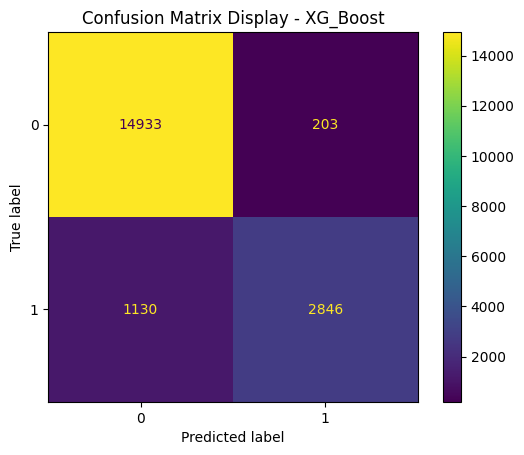

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb2,
                               display_labels=xgb_model2.classes_)
disp.plot()
plt.title("Confusion Matrix Display - XG_Boost")
plt.show()

In [ ]:
print(classification_report(y_train_final, y_train_pred_XG2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     15136
           1       0.93      0.72      0.81      3976

    accuracy                           0.93     19112
   macro avg       0.93      0.85      0.88     19112
weighted avg       0.93      0.93      0.93     19112



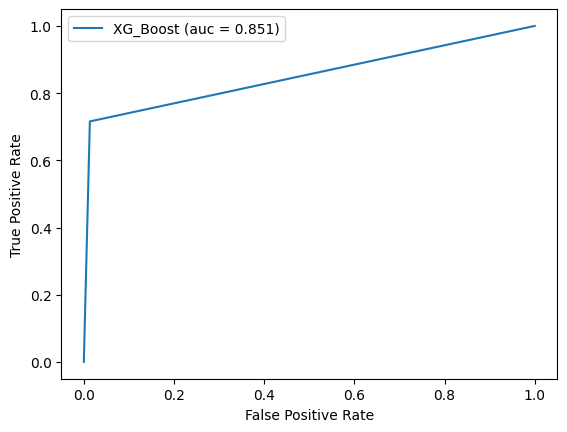

In [ ]:
fpr_xg2, tpr_xg2, threshold_roc_XG2 = roc_curve(y_train_final, y_train_pred_XG2)
auc_xg2 = auc(fpr_xg2, tpr_xg2)

plt.plot(fpr_xg2, tpr_xg2, linestyle="-", label="XG_Boost (auc = %0.3f)" % auc_xg2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

#### Validation_set

In [ ]:
y_valid_pred_XG2 = xgb_model2.predict(X_valid_scaled)

cm_val_SGD2 = confusion_matrix(y_valid_final, y_valid_pred_XG2)

In [ ]:
print(classification_report(y_valid_final, y_valid_pred_XG2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1903
           1       0.94      0.71      0.81       497

    accuracy                           0.93      2400
   macro avg       0.93      0.85      0.88      2400
weighted avg       0.93      0.93      0.93      2400



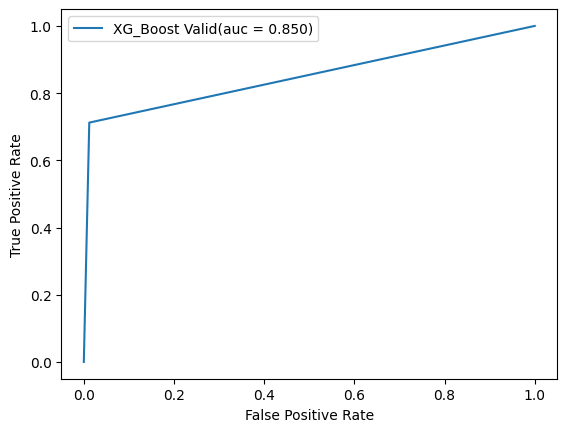

In [ ]:
fpr_V_xg2, tpr_V_xg2, threshold_V_roc_XG = roc_curve(y_valid_final, y_valid_pred_XG2)
auc_V_xg2 = auc(fpr_V_xg2, tpr_V_xg2)

plt.plot(fpr_V_xg2, tpr_V_xg2, linestyle="-", label="XG_Boost Valid(auc = %0.3f)" % auc_V_xg2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

### Logistic Regression

In [ ]:
lg_clf2 = LogisticRegression()

lg_clf2.fit(X_train_scaled, y_train_final)

LogisticRegression()

In [ ]:
y_train_pred_lg2 = cross_val_predict(lg_clf2, X_train_scaled, y_train_final, cv=5)

cm_lg2 = confusion_matrix(y_train_final, y_train_pred_lg2)

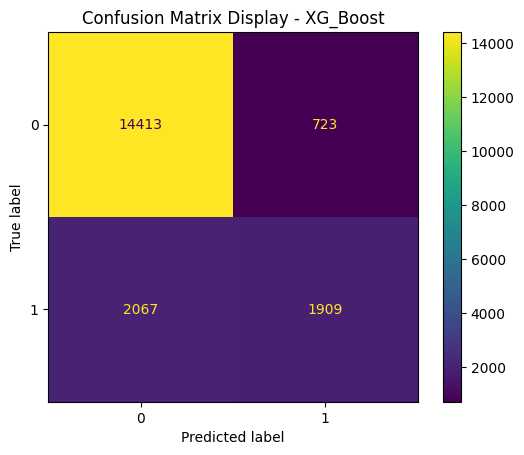

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg2,
                               display_labels=lg_clf2.classes_)
disp.plot()
plt.title("Confusion Matrix Display - XG_Boost")
plt.show()

In [ ]:
print(classification_report(y_train_final, y_train_pred_lg2))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     15136
           1       0.73      0.48      0.58      3976

    accuracy                           0.85     19112
   macro avg       0.80      0.72      0.74     19112
weighted avg       0.84      0.85      0.84     19112



#### validation set

In [ ]:
y_valid_pred_lg2 = lg_clf2.predict(X_valid_scaled)

cm_val_lg2 = confusion_matrix(y_valid_final, y_valid_pred_lg2)

In [ ]:
print(classification_report(y_valid_final, y_valid_pred_lg2))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1903
           1       0.77      0.48      0.60       497

    accuracy                           0.86      2400
   macro avg       0.82      0.72      0.76      2400
weighted avg       0.86      0.86      0.85      2400



### Model comparison

Our main goal is to improve on the recall metric in order to still maintain business profit.

*   Recall or True Positive Rate indicates all the positive class correctly identified (in this case default applicant) amongst all the available positive class. In our case, a False Negative would mean that our model mistakenly classifies a person who will default on their loan as not going to default. **This decision could lead to a huge loss for the business**.

*   By maximizing Recall, **we aim to catch as many of the actual defaulters as possible** i.e., all people who will not be able to pay back their loans.

* However, This might lead to denying loans to many applicants who would actually have been able to repay their loans, potentially leading to lost business opportunities

Therefore we would like to create a custom metric to balance the potential loss as well as opportunity cost.



In [ ]:
def business_metrics(y_true, y_pred):
    # Define weights
    false_negative_weight = 5 ## recall metrics count higher // potential loss
    false_positive_weight = 1 ## opportunity loss

    # Get confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Extract FP and FN values
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]

    # Calculate cost
    cost = (false_negative_weight * FN) + (false_positive_weight * FP)

    return cost


---

**Logistic Regression**





In [ ]:
### USING PRE-PROCESS 1
print(classification_report(y_valid, y_valid_pred_lg))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2533
           1       0.74      0.51      0.61       709

    accuracy                           0.85      3242
   macro avg       0.81      0.73      0.76      3242
weighted avg       0.85      0.85      0.84      3242



In [ ]:
PP1_business = business_metrics(y_valid, y_valid_pred_lg)
print(PP1_business)

1857


In [ ]:
### USING PRE-PROCESS 2
print(classification_report(y_valid_final, y_valid_pred_lg2))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1903
           1       0.77      0.48      0.60       497

    accuracy                           0.86      2400
   macro avg       0.82      0.72      0.76      2400
weighted avg       0.86      0.86      0.85      2400



In [ ]:
PP2_business = business_metrics(y_valid_final, y_valid_pred_lg2)
print(PP2_business)

1351


In [ ]:
perc_business = ((PP1_business - PP2_business) / PP1_business) * 100
print(f"Our business loss has changed to: {round(perc_business,2)} %")
print("(-): means more loses ; (+) means less loses overall")

Our business loss has changed to: 27.25 %
(-): means more loses ; (+) means less loses overall


Logistic Regression conclusion:

1.   The second preprocessing step did not significantly increase our model's performance. Although we observed a minimal accuracy increase of 1%, this was coupled with a reduced recall for the positive class. However, this trade-off benefitted the model's precision in predicting default classes, which improved by 3%.

2.   Major improvement is visible for our business metrics where we may evade 27.25% less business losses. Again this metrics shows the combine risk of opportunity & real loss. Through the preprocessing data we showed that our threshold methods are effective in reducing potential candidates that might default on their loan

3. Another observation on the trade-off is probably caused by the losses in training data through the preprocessing step. In the second iteration of our preprocessing we introduced more safe guarding methods and thus remove around 4000 observations from the training set.  




---

**XG Boost**





In [ ]:
print(classification_report(y_valid, y_valid_pred_XG))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2533
           1       0.95      0.74      0.83       709

    accuracy                           0.93      3242
   macro avg       0.94      0.87      0.90      3242
weighted avg       0.94      0.93      0.93      3242



In [ ]:
PP1XG_business = business_metrics(y_valid, y_valid_pred_XG)
print(PP1XG_business)

940


In [ ]:
print(classification_report(y_valid_final, y_valid_pred_XG2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1903
           1       0.94      0.71      0.81       497

    accuracy                           0.93      2400
   macro avg       0.93      0.85      0.88      2400
weighted avg       0.93      0.93      0.93      2400



In [ ]:
PP2XG_business = business_metrics(y_valid_final, y_valid_pred_XG2)
print(PP2XG_business)

738


In [ ]:
perc_businessXG = ((PP1XG_business - PP2XG_business) / PP1XG_business) * 100
print(f"Our business loss has changed to: {round(perc_businessXG,2)} %")
print("(-): means more loses ; (+) means less loses overall")

Our business loss has changed to: 21.49 %
(-): means more loses ; (+) means less loses overall


The performance for our XG Boost model has similar result with the logistic regression approach with overall better percentage on almost all metrics. Most notable increased is in accuracy and f1-score.

1. the additional preprocessing step however do not give any positive performance boost to our model as shown by the reduction of all metrics for class 1 :recall (**-3%**) , precision(**-1%**) , f1-score (**-2%**), accuracy (0%)

2. However the performance improvement is seen on our business metrics where 21.5% reduction in combine loses is calculated between method 1 and method 2. Furthermore, the best XG boost model has the lowest score for business metric loss with 738 in comparison to logistic regression model (best model: 1351)

To conclude our experiment, most improvements after preprocessing steps are seen in **business metrics**, with a 27.25% to 21.5% loss reduction between methods, and the** XGBoost model shows the lowest loss score.**

# Archive

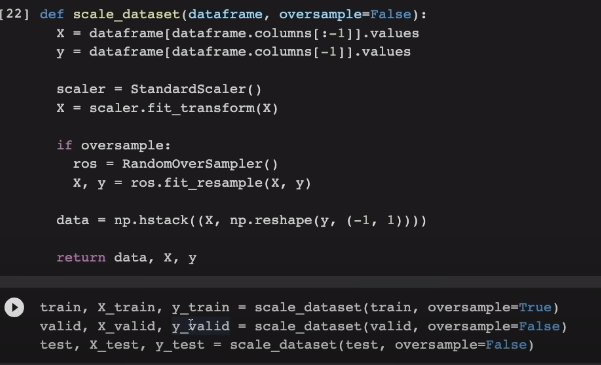